# Advanced Computer Vision - Photometric Stereo

Selim Karaoglu  
karaoglu@hawaii.edu

In this paper, we implement a standard photometric stereo algorithm. With the albedo being unknown and not constant for the images, this program takes multiple images and light source direction information as an input and produce the albedo map, surface normals map, heights map and 3d plot of the surface for provided input. All the images used in this project are stored in "src" folder. Several output plots shown in the work are stored in the "out" folder.

In [1]:
#Libraries used for this work
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D
#For DCT
from scipy import fftpack as fft

## Photometric Stereo

Photometric stereo is a method used in computer vision for estimating the surface normals of objects by observing that object under different lighting conditions. This technique was introduced to computer sciences in 1980 by Woodham. He suggested the problem can be solved by inverting the linear equation $I = L.n$ where $I$ is a vector of observed intensity values, $n$ is a surface normal (unknown) and $L$ is a matrix of light directions. We can use this approach to find surface normals for series of images under different lighting.  
For Lambertian surfaces, intentity at any point on the surface can be given as:  
>$I = k_dN.L$

Where N is the normal at the surface point and L is the reflected light direction. In order to determine N, we need at least three light source which are not in the same plane. Therefore the above equations can be written as:
>$I_1 = k_d(N_x*L_{1x}+N_yL_{1y}+N_zL_{1y})$  
>$I_2 = k_d(N_x*L_{2x}+N_yL_{2y}+N_zL_{2y})$  
>$I_3 = k_d(N_x*L_{3x}+N_yL_{3y}+N_zL_{3y})$  
>...  
>$I_n = k_d(N_x*L_{nx}+N_yL_{ny}+N_zL_{ny})$  

Let us denote:
>$[G] = k_d[N]$  

So for n > 3, we can solve the equations with least square methods as;
>$[L]G = I$  
>$L^TLG=L^TI$  
>$G = (L^TL)^{-1}L^TI$  
>$k_d = ||G||$  
>$N = G/k_d$  

We start the project with defining our main functions:

In [2]:
#Function to read images and light arrays
def get_stuff():
    '''This function loads the images. Images are
    stored in the "src" folder. Light arrays are stored in ".txt" files
    in the same folder.
    '''
    #Loading the synthetic & real images' light arrays from text file
    lights_synt = np.array(np.loadtxt('./src/lights_s.txt', delimiter = ','))
    lights_real = np.array(np.loadtxt('./src/lights_r.txt', delimiter = ','))
    #Loading grayscale synthetic & real images as arrays in a list
    images_synt, images_real = [], []
    for i in range(4):
        file_s = "./src/im" + str(i+1) + ".png"
        file_r = "./src/real" + str(i+1) + ".bmp"
        img_s = np.asarray(Image.open(file_s).convert("L"))
        img_r = np.asarray(Image.open(file_r).convert("L"))
        images_synt.append(img_s)
        images_real.append(img_r)
    #Converting lists to arrays
    images_synt = np.asarray(images_synt)
    images_real = np.asarray(images_real)
    
    return images_synt, lights_synt, images_real, lights_real

Now we assign the data values to variables using the $get\_stuff()$ function

In [3]:
#Get Image and Light arrays
images_synt, lights_synt, images_real, lights_real = get_stuff()

### Albedo

This function computes albedo map for given images list and light source direction matrix list. The output of the function is Albedo matrix and G.

In [4]:
#Funtion to compute albedo map
def albedo_map(images, S):
    '''This function computes albedo map with corresponding light source information
    and estimated surface normals, returns albedo map.
    Params
    @images   : List of grayscale images as arrays.
    @light    : Light source position arrays for each image.'''
    #Constructing Intensity matrix; I
    #Dimensions for I
    _x = images.shape[0]
    _y = images.shape[1]
    _z = images.shape[2]
    #Reshaping I
    I = images.reshape(_x, _y*_z)
    #Intensity values replaced by their normalized (I/255) values 
    I = I/255
    #Pseudo-inverse method to exclude shadow points
    G = np.dot(np.dot(np.linalg.pinv(np.dot(S.T, S)), S.T), I)
    #Create albedo matrix and assign the albedo values; albedo_matrix
    albedo_matrix = np.sqrt(G[0]**2 + G[1]**2 + G[2]**2)
    albedo_matrix = albedo_matrix.reshape(_y, _z)    
                             
    return albedo_matrix, G

### Estimated Surface Normals

This function computes estimated surface normals for given images list, albedo map and G. The output of the function is estimated surface normals matrix.

In [5]:
#Function to compute estimated surface normals
def surface_normals(images, a, G):
    '''This function computes estimated surface normals for given images using
    images and calculated albedo information, returns surface normals matrix.
    Params
    @images         : List of grayscale images as arrays.
    @albedo_matrix  : Calculated albedo map of images.
    @G              : Dot product results of pseudo-inverse method'''
    #Create empty normals matrix; normals_matrix
    #Dimensions for normals matrix; image height and width
    _y = images.shape[1]
    _z = images.shape[2]
    #Assigning normals for each G
    N = []
    for i in range(len(G)):
        N.append(np.asarray((G[i] / a.ravel()).reshape(_y, _z)))
    normals_matrix = np.array([N[0], N[1], N[2]])
    return normals_matrix

### Surface Heights (Depth)

Below functions are used to calculate surface height maps. First function is designed to work as explained previously. Second function uses a method developed by Simchony et al. that calculates the depth map by using hybrid DCT / finite difference methods.

In [6]:
def height_map(n):
    h = np.zeros(n[0].shape)
    p = -n[0]/n[2]
    q = -n[1]/n[2]
    for i, height in np.ndenumerate(h):
        h[i] = np.sum([q[0, y] for y in range(0, i[1]+1)]) + np.sum([p[x, i[1]] for x in range(0, i[0]+1)])
    return h

In [7]:
def div_x(f):
    _x = f.shape[0]
    _w = [0] + list(range(_x-1))
    _e = list(range(1,_x)) + [_x-1]
    return 0.5*(f[_e,:] - f[_w,:])

def div_y(f):
    _y = f.shape[1]
    _s = [0] + list(range(_y-1))
    _n = list(range(1,_y)) + [_y-1]
    return 0.5*(f[:,_n] - f[:,_s])

def height_map2(n):
    _x, _y = n[0].shape
    h = np.zeros(n[0].shape)
    p = -n[0]/n[2]
    q = -n[1]/n[2]
    #Central differences for p    
    p_x = div_x(p)
    q_y = div_y(q)
    #4 Edges
    _f = p_x + q_y
    _f[0,1:-1]  = 0.5*(p[0,1:-1] + p[1,1:-1])    
    _f[-1,1:-1] = 0.5*(-p[-1,1:-1] - p[-2,1:-1])
    _f[1:-1,0]  = 0.5*(q[1:-1,0] + q[1:-1,1])
    _f[1:-1,-1] = 0.5*(-q[1:-1,-1] - q[1:-1,-2])
    #4 Corners
    _f[ 0, 0] = 0.5*(p[0,0] + p[1,0] + q[0,0] + q[0,1])
    _f[-1, 0] = 0.5*(-p[-1,0] - p[-2,0] + q[-1,0] + q[-1,1])
    _f[ 0,-1] = 0.5*(p[0,-1] + p[1,-1] - q[0,-1] - q[1,-1])
    _f[-1,-1] = 0.5*(-p[-1,-1] - p[-2,-1] -q[-1,-1] -q[-1,-2])
    #Cosine transform f
    fs = fft.dct(_f, axis=0, norm='ortho')
    fs = fft.dct(fs, axis=1, norm='ortho')    
    x, y = np.mgrid[0:_x,0:_y]
    denum = (2*np.cos(np.pi*x/_x) - 2) + (2*np.cos(np.pi*y/_y) -2)
    Z = fs/denum
    Z[0,0] = 0.0
    z = fft.dct(Z, type=3, norm='ortho', axis=0)
    z = fft.dct(z, type=3, norm='ortho', axis=1)
    
    return z

## Results

With the code below, we use the functions defined above and store the results in variables to use later. As can be seen from the code, we assigned synthetic images' albedo mapping in variable "a_s", G in "G_s" and real images' albedo mapping in "a_r", G in "G_r".

In [8]:
#Albedo maps and surface normals for synthetic images
a_s, G_s = albedo_map(images_synt, lights_synt)
n_s = surface_normals(images_synt, a_s, G_s)
#Albedo maps and surface normals for real images
a_r, G_r = albedo_map(images_real, lights_real)
n_r = surface_normals(images_real, a_r, G_r)
#Converting normalized albedo values for plotting
A_s = a_s * 255
A_r = a_r * 255

### Albedo Map results:

Now we can plot the albedo maps for different image sets. Below code plots the albedo mapping for synthetic and real image sets respectively.

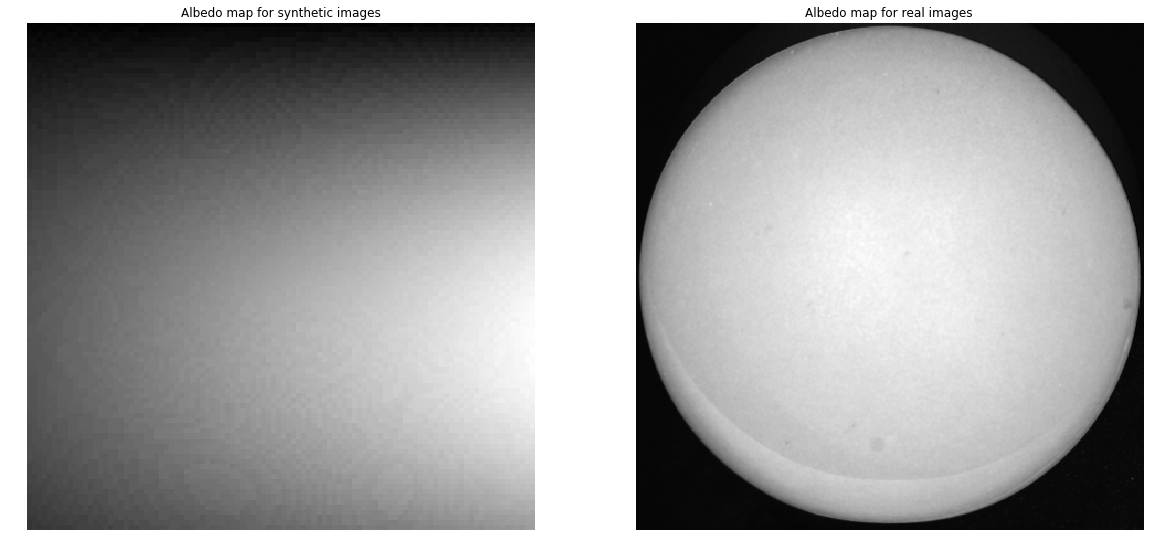

In [9]:
#Plotting the Albedo maps for sythetic and real images
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(A_s, cmap='gray')
ax[0].set_title("Albedo map for synthetic images")
ax[0].set_axis_off()
ax[1].imshow(A_r, cmap='gray')
ax[1].set_title("Albedo map for real images")
ax[1].set_axis_off()
plt.savefig("./out/albedosPlot.png")
plt.show()

The code below calls the functions defined above to calculate the surface heights maps for given surface normals and assign the results to variables. We used two different functions and we compared the results.

In [10]:
h_s = height_map(n_s)
h_r = height_map(n_r)
h_s2 = height_map2(n_s)
h_r2 = height_map2(n_r)

C:\Users\User\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide


### Value Comparison:

First we compare the small region results to the ".pdf" file provided by the Professor to compare the function results.

In [11]:
#Comparing the results with the .pdf file results
print("Albedo map for synthetic images [(46,51)-(46,51)]")
print(a_s[46:51, 46:51])
print("x - surface normals for synthetic images [(46,51)-(46,51)]")
print(n_s[0][46:51, 46:51])
print("y - surface normals for synthetic images [(46,51)-(46,51)]")
print(n_s[1][46:51, 46:51])
print("z - surface normals for synthetic images [(46,51)-(46,51)]")
print(n_s[2][46:51, 46:51])

Albedo map for synthetic images [(46,51)-(46,51)]
[[0.54580486 0.54935758 0.55208489 0.55764927 0.55973858]
 [0.55052276 0.55429499 0.55716376 0.559961   0.56491198]
 [0.55440134 0.55831265 0.56222867 0.56504619 0.5690709 ]
 [0.55729256 0.5626707  0.56640539 0.56896542 0.57422532]
 [0.56518226 0.56886818 0.57187899 0.57789606 0.57964276]]
x - surface normals for synthetic images [(46,51)-(46,51)]
[[ 0.20357296  0.20225644  0.20125729  0.21096963  0.19850537]
 [ 0.13059483  0.12970607  0.12903823  0.10504933  0.12726837]
 [ 0.058946    0.05853304  0.04650028  0.03470131  0.05742648]
 [-0.01172804 -0.02323188 -0.03461804 -0.03446228 -0.0341466 ]
 [-0.10407887 -0.11489389 -0.114289   -0.13571882 -0.1127582 ]]
y - surface normals for synthetic images [(46,51)-(46,51)]
[[ 2.33510161e-01  1.60615411e-01  8.87899825e-02 -9.95449196e-17
  -8.75758967e-02]
 [ 2.31509011e-01  1.59184721e-01  8.79806103e-02 -1.98267919e-16
  -8.67738855e-02]
 [ 2.29889381e-01  1.58039217e-01  8.71880266e-02 -1.96

In [12]:
print("Height map for synthetic images [(46,51)-(46,51)]")
print(h_s[46:51, 46:51])
print("Height map for synthetic images [(46,51)-(46,51)]")
print(h_r[46:51, 46:51])
print("Height map 2 for synthetic images [(46,51)-(46,51)]")
print(h_s2[46:51, 46:51])
print("Height map 2 for real images [(46,51)-(46,51)]")
print(h_r2[46:51, 46:51])

Height map for synthetic images [(46,51)-(46,51)]
[[84.82706073 84.90774051 84.9354595  84.4545789  85.49310466]
 [84.96252871 85.04027064 85.06610083 84.5602127  85.62191028]
 [85.02320832 85.09965306 85.1128298  84.59493492 85.679647  ]
 [85.01116013 85.07612365 85.07810758 84.56045217 85.64540043]
 [84.90324646 84.95902763 84.96263414 84.42346586 85.53150521]]
Height map for synthetic images [(46,51)-(46,51)]
[[-0.29781457 -0.35974376 -0.43024271 -0.66944644 -0.83768976]
 [-0.22552507 -0.27679104 -0.34728999 -0.56835458 -0.73659789]
 [-0.14257235 -0.19383832 -0.26433727 -0.45857316 -0.62707732]
 [-0.05961963 -0.08193646 -0.15243542 -0.36694681 -0.51755674]
 [ 0.00320811  0.00101626 -0.0694827  -0.25504495 -0.40803616]]
Height map 2 for synthetic images [(46,51)-(46,51)]
[[43.76485459 43.96441758 44.09088599 44.14313532 44.09716671]
 [43.9276284  44.13129368 44.26005388 44.30898954 44.2638412 ]
 [44.01912425 44.22210033 44.34748128 44.3894785  44.35020499]
 [44.03631046 44.23750662 4

### Surface Normals Map results:

We observed the functions are working and producing right results. Now we plot the results we computed. First we plotted the surface normals for synthetic and real images respectively.

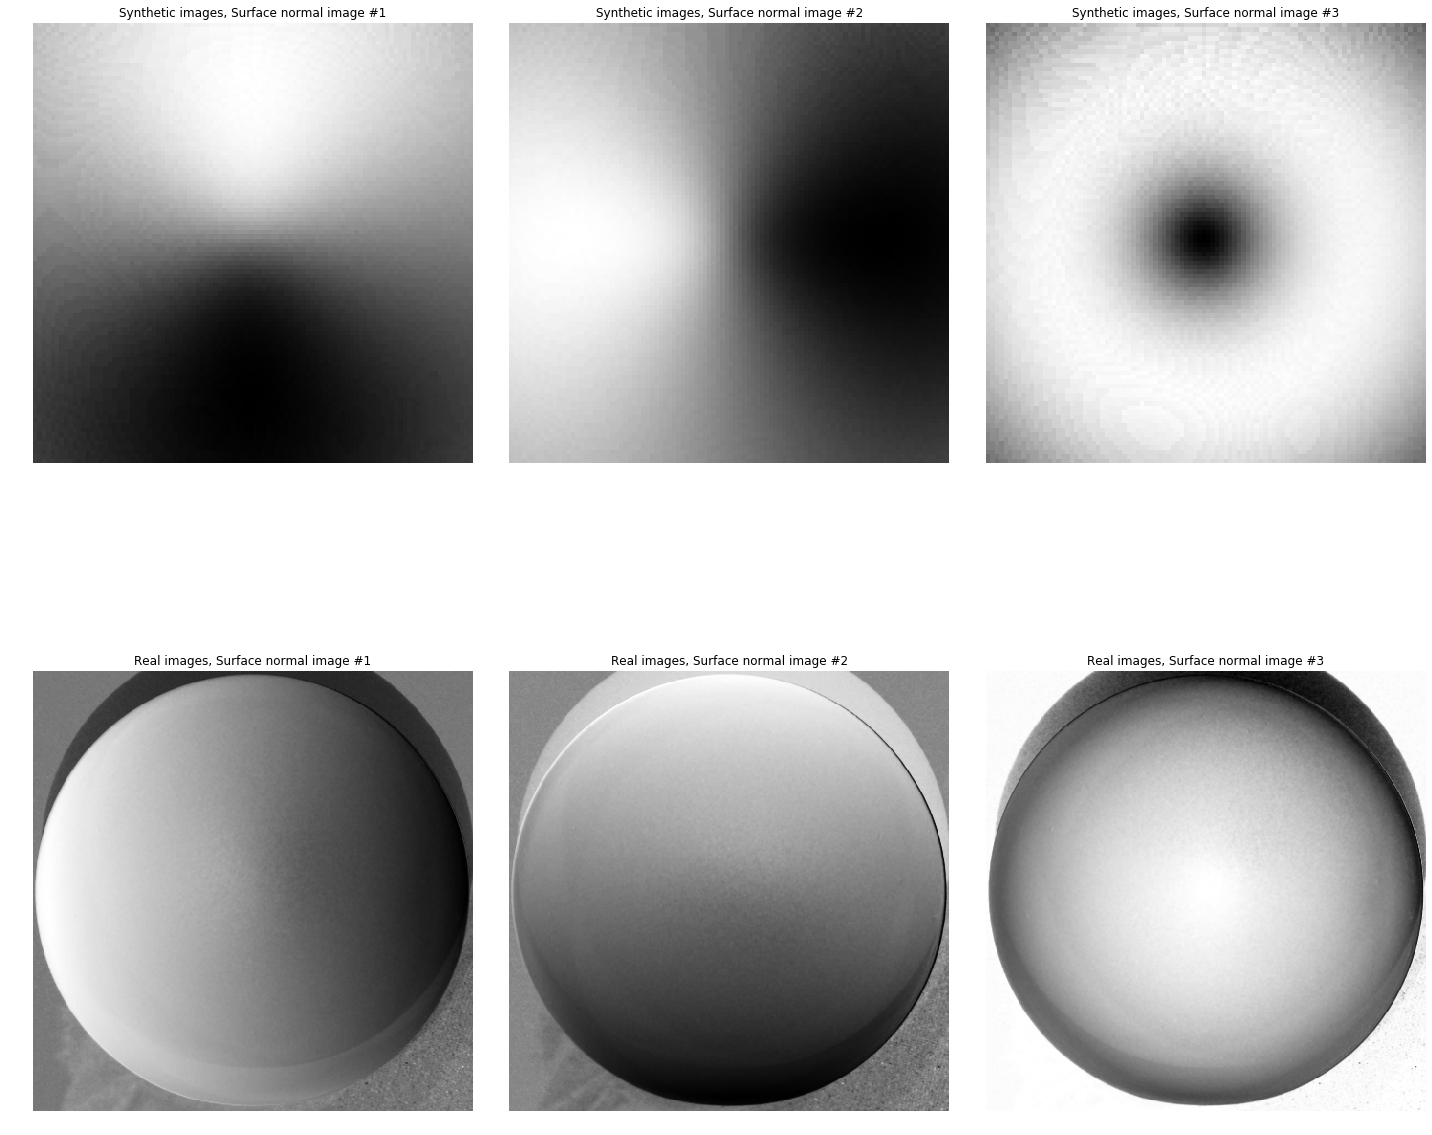

In [13]:
#Surface normals plots
fig = plt.figure(figsize=(20, 20))
for i in range(3):
    ax = fig.add_subplot(2, 3, i+1)
    ax2 = fig.add_subplot(2, 3, i+4)
    ax.imshow(n_s[i]*255, cmap='gray')
    ax.set_title("Synthetic images, Surface normal image #" + str(i+1))
    ax.set_axis_off()
    ax2.imshow(n_r[i]*255, cmap='gray')
    ax2.set_title("Real images, Surface normal image #" + str(i+1))
    ax2.set_axis_off()
plt.tight_layout()
plt.savefig("./out/normalsPlot.png")
plt.show()

### 3D Plots of Height Map results:

Here we plot the 3d surface heights maps using matplotlib 3d plotting. Top row belongs to synthetic images and the second row is for real images, while the first image is least squares method and the second image is DCT method.

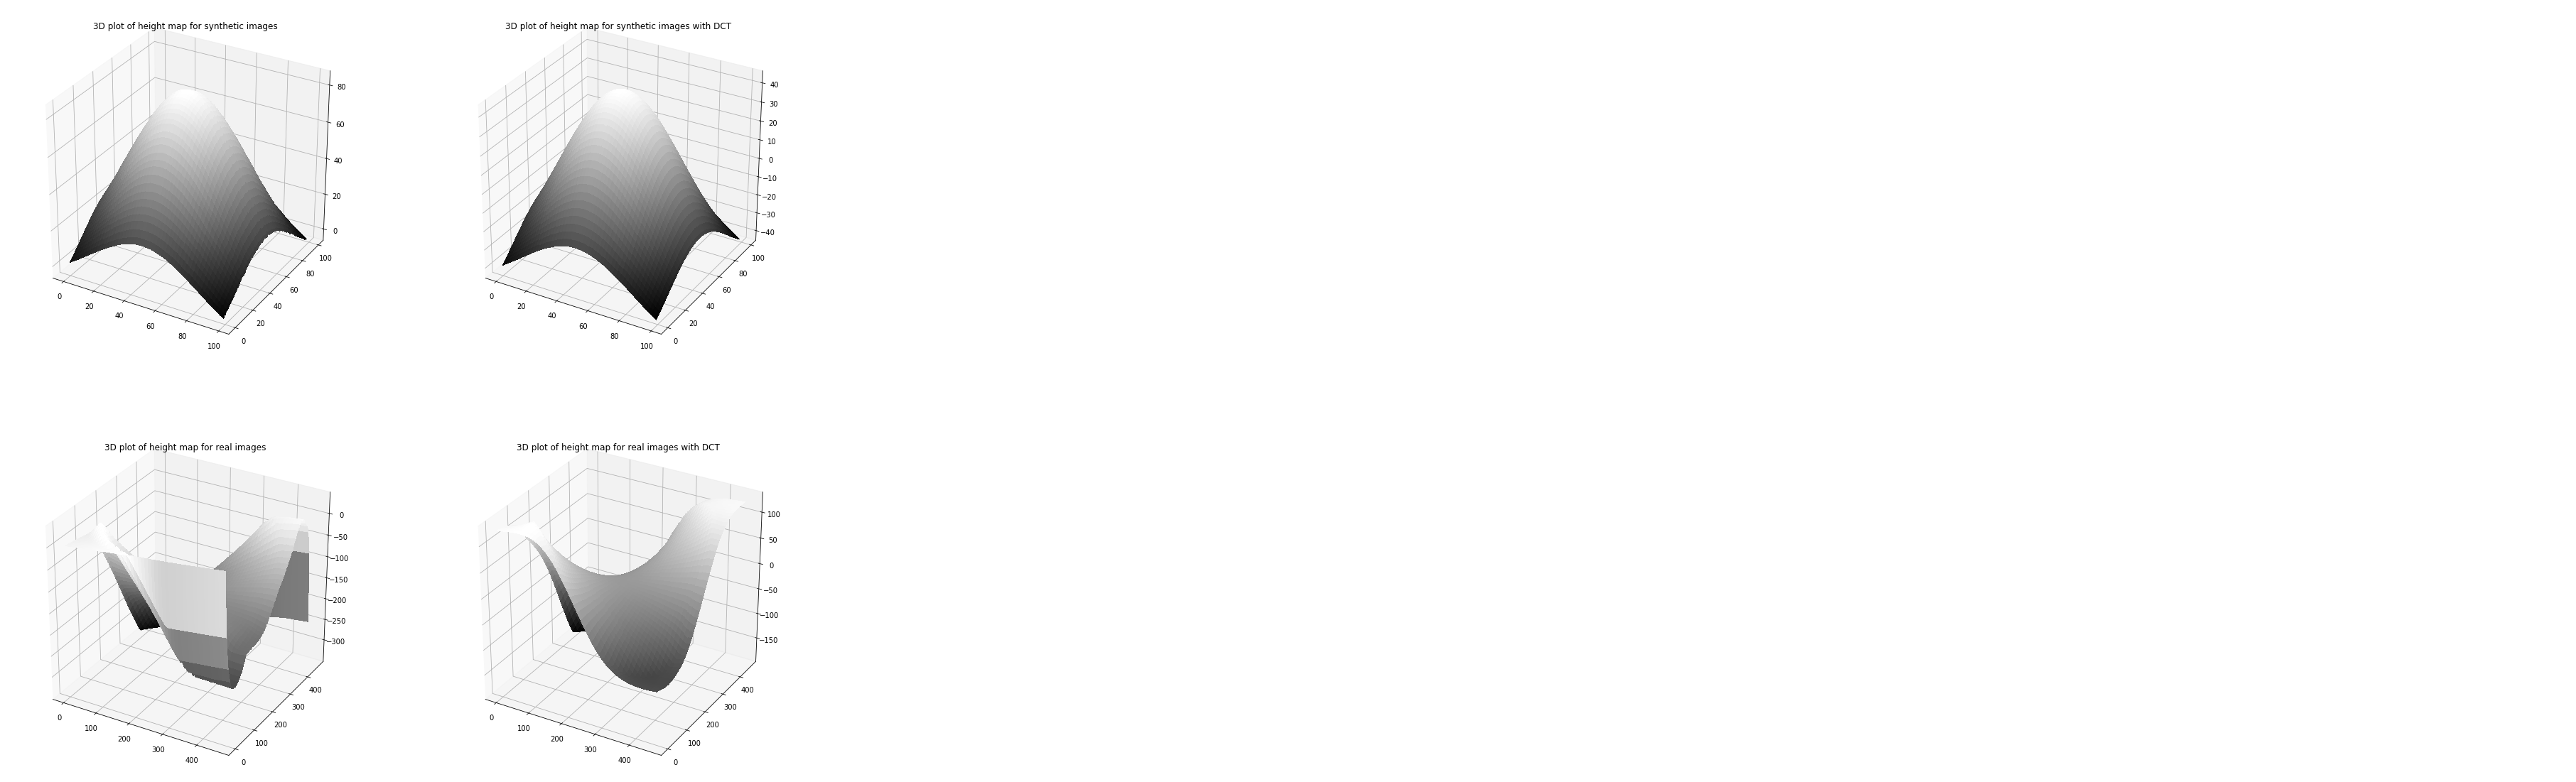

In [19]:
z = [h_s, h_s2, h_r, h_r2]
t = ["synthetic images", "synthetic images with DCT", "real images", "real images with DCT"]
fig = plt.figure(figsize=(20,20))
for i in range(4):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.set_title("3D plot of height map for " + t[i])
    Z = z[i]
    _X, _Y = Z.shape
    X, Y = np.mgrid[0:_X, 0:_Y]
    surf = ax.plot_surface(X, Y, Z, cmap='gray', linewidth=0, antialiased=False)
plt.savefig("./out/3DheightsPlot.png")
plt.show()

### 2D plots of Height Map results:

To plot the estimated height maps on 2 dimensional plot, we have to multiply the values with 255.

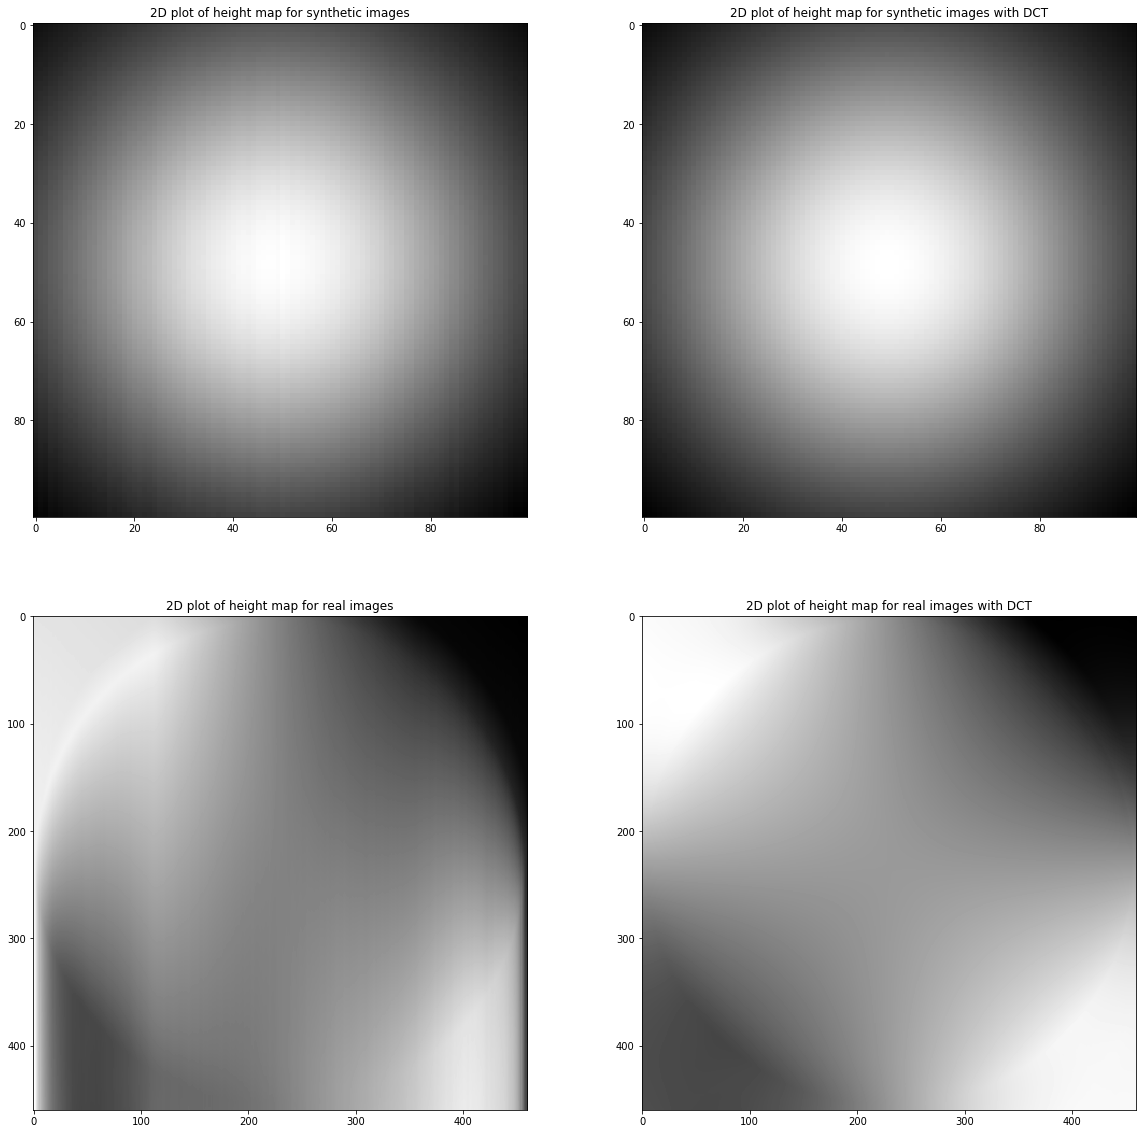

In [20]:
z = [h_s, h_s2, h_r, h_r2]
t = ["synthetic images", "synthetic images with DCT", "real images", "real images with DCT"]
fig = plt.figure(figsize=(20,20))
for i in range(4):
    ax = fig.add_subplot(2, 2, i+1)
    ax.set_title("2D plot of height map for " + t[i])
    ax.imshow(z[i]*255, cmap='gray')
plt.savefig("./out/2DheightsPlot.png")
plt.show()

## Summary

In this paper we applied standard photometric stereo algorithm. First we used sets of images under different lighting conditions and their light source direction arrays as our inputs. We can calculate albedo with the given input of 3+ number of images. Since we had 4 images for each set, this condition is satisfied and calculating albedo is no problem. After calculating albedo, we calculated the surface normals using images and calculated albedo and G. The last step is to plot the height maps on 3d plot. We achieved that by using 3d plotting with matplotlib library.